# WOfS Imputation <img align="right" src="../../../Supplementary_data/dea_logo.jpg">

* **Compatibility:** Notebook currently compatible with both the NCI and DEA Sandbox environments. 
* **Products used:** 
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3)

## Description

There are plenty of missing data in our time series of Australian waterbodies, not least due to Landsat 7's scan line corrector failing in May 2003. In this notebook we impute missing data on a scene-by-scene basis in a few different ways.

We will run WOfS ourself since we do not want the terrain mask &mdash; we know where the waterbody is and we can ignore the terrain masking for this analysis.

## Getting started

To run this analysis, work through this notebook starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import sys
from pathlib import Path

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.insert(1, "../../../Scripts")
import fuzzy_wofs
from dea_datahandling import mostcommon_crs
from dea_spatialtools import xr_rasterize
from dea_waterbodies import get_waterbody

/env/lib/python3.6/site-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)


## Analysis parameters

This section lets you set parameters for the analysis.

### Choose a waterbody

Specify the geohash of a waterbody here:

In [2]:
geohash = "r282x882w"  # Lagoon of Islands

## Estimate WOfS for the full time stack

Load all data for this waterbody and estimate WOfS.

### Load Landsat

Fetch the waterbody polygon extents:

In [3]:
wb = get_waterbody(geohash)

In [4]:
xlim = wb.total_bounds[::2]
ylim = wb.total_bounds[1::2]

Set up the datacube:

In [5]:
# Set up the datacube to get DEA data.
dc = datacube.Datacube(app="WOfSImputation")

# Some query parameters.
dask_chunks = {"x": 3000, "y": 3000, "time": 1}

Then load Landsat 7:

In [6]:
# To load in native resolution and projection we need to find the native CRS.
output_crs = mostcommon_crs(
    dc, product="ga_ls7e_ard_3", query=dict(x=xlim, y=ylim, crs="EPSG:3577")
)

In [7]:
query = dict(
    x=xlim,
    y=ylim,
    crs="EPSG:3577",
    output_crs=output_crs,  # Native CRS
    align=(
        15,
        15,
    ),  # Required for loading native resolution and CRS Landsat Collection 3
    resolution=(-30, 30),  # Native resolution
    dask_chunks=dask_chunks,
    group_by="solar_day",
    measurements=[
        "nbart_blue",
        "nbart_green",
        "nbart_red",
        "nbart_nir",
        "nbart_swir_1",
        "nbart_swir_2",
        "oa_fmask",
        "oa_nbart_contiguity",
    ],
)

In [8]:
ls7 = dc.load("ga_ls7e_ard_3", **query)

Check that everything will fit into memory before we load it:

In [9]:
n_px = ls7.sizes["time"] * ls7.sizes["x"] * ls7.sizes["y"]
est = (6 * n_px * 16 + 2 * n_px * 8) // 8 / 1e9
print("Estimated:", est, "GB")

assert est < 40

Estimated: 0.187979792 GB


Then load it explicitly with dask:

In [10]:
ls7.load()

<xarray.Dataset>
Dimensions:              (time: 776, x: 143, y: 121)
Coordinates:
  * time                 (time) datetime64[ns] 1999-08-10T23:45:11.304012 ......
  * y                    (y) float64 -4.659e+06 -4.659e+06 ... -4.662e+06
  * x                    (x) float64 4.921e+05 4.921e+05 ... 4.963e+05 4.963e+05
    spatial_ref          int32 32655
Data variables:
    nbart_blue           (time, y, x) int16 53 53 52 1 101 ... 147 192 194 173
    nbart_green          (time, y, x) int16 170 358 288 218 ... 311 312 289 318
    nbart_red            (time, y, x) int16 401 347 338 374 ... 385 407 345 394
    nbart_nir            (time, y, x) int16 1727 1796 1679 ... 1496 1412 1475
    nbart_swir_1         (time, y, x) int16 1114 1114 1019 ... 1286 1325 1227
    nbart_swir_2         (time, y, x) int16 579 578 492 470 ... 672 761 709 778
    oa_fmask             (time, y, x) uint8 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    oa_nbart_contiguity  (time, y, x) uint8 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    crs:           epsg:32655
    grid_mapping:  spatial_ref

We can then combine some masks. We will mask with a combination of fmask, contiguity, valid data, and within the waterbody maximum extent:

In [11]:
wb_raster = xr_rasterize(wb, ls7)

In [12]:
mask = (ls7.oa_fmask == 1) | (ls7.oa_fmask == 4) | (ls7.oa_fmask == 5)
mask &= ls7.oa_nbart_contiguity == 1
mask &= (ls7 > -999).to_array().all(axis=0)
mask &= wb_raster == 1

Convert the cube into a format that WOfS will accept.

In [13]:
ls7_cube = ls7[
    [
        "nbart_blue",
        "nbart_green",
        "nbart_red",
        "nbart_nir",
        "nbart_swir_1",
        "nbart_swir_2",
    ]
].to_array(dim="band")

Finally we can go ahead and estimate WOfS.

In [14]:
wofs = fuzzy_wofs.wofs.predict(ls7_cube)

We can reproduce the WOfS all-time summary by taking the mean, which will let us confirm that everything worked OK:

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


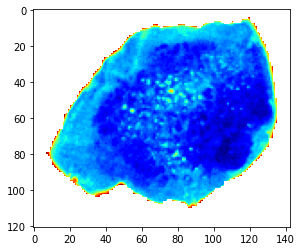

In [15]:
plt.imshow(np.nanmean(np.where(mask, wofs, np.nan), axis=0), cmap="jet_r")

That looks like it matches the all-time summary, and the islands in the middle of the lagoon are clearly visible.

## Baseline comparison: Time series without imputing WOfS

First we will try matching DEA Waterbodies. Throw out all time steps with <90% pixels:

In [16]:
wb_area_px2 = wb_raster.sum()

In [17]:
ok = mask.sum(axis=(1, 2)) >= wb_area_px2 * 0.9

Then just sum up the pixel counts.

In [18]:
ts_baseline = pd.Series(
    np.nansum(np.where(mask, wofs, np.nan), axis=(1, 2)), index=ls7.time.values
)
ts_baseline = ts_baseline.mask(~ok)

In [19]:
n_nodata = pd.Series((~mask & (wb_raster == 1)).sum(axis=(1, 2)), index=ls7.time.values)
pc_nodata = n_nodata / int(wb_area_px2)

We can plot tihs with linear interpolation to join the water surface area time series:

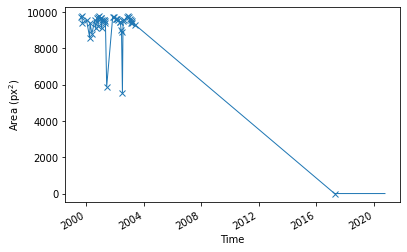

In [20]:
fig, ax = plt.subplots()
ts_baseline.plot(ax=ax, linewidth=0, marker="x", c="C0")
ts_baseline.interpolate(method="time").plot(ax=ax, linewidth=1, c="C0")
ax.set_xlabel("Time")
ax.set_ylabel("Area (px$^2$)");

Different thresholds for "good data" can change this substantially.

In [21]:
ok_low = mask.sum(axis=(1, 2)) >= wb_area_px2 * 0.75

In [22]:
ts_baseline_low = pd.Series(
    np.nansum(np.where(mask, wofs, np.nan), axis=(1, 2)), index=ls7.time.values
)
ts_baseline_low = ts_baseline_low.mask(~ok_low)

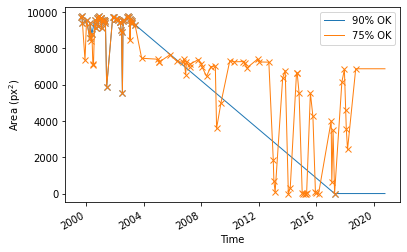

In [23]:
fig, ax = plt.subplots()
ts_baseline.plot(ax=ax, linewidth=0, marker="x", c="C0", label="_nolegend_")
h1 = ts_baseline.interpolate(method="time").plot(
    ax=ax, linewidth=1, c="C0", label="90% OK"
)
ts_baseline_low.plot(ax=ax, linewidth=0, marker="x", c="C1", label="_nolegend_")
h2 = ts_baseline_low.interpolate(method="time").plot(
    ax=ax, linewidth=1, c="C1", label="75% OK"
)
plt.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Area (px$^2$)");

It's useful here to estimate how far out we might be, because this is really a _lower bound_ on how many wet pixels there are &mdash; we're essentially assuming all missing pixels are dry, so why not assume all missing pixels are wet? That would instead give us an upper bound.

In [24]:
ts_baseline_upper = pd.Series(
    np.where(ok, wofs.sum(axis=(1, 2)) + n_nodata, np.nan), index=ls7.time.values
)
ts_baseline_low_upper = pd.Series(
    np.where(ok_low, wofs.sum(axis=(1, 2)) + n_nodata, np.nan), index=ls7.time.values
)

We can then plot the lower and upper bounds:

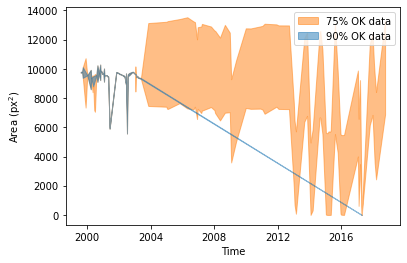

In [25]:
fig, ax = plt.subplots()

as_bars = False

if as_bars:
    ax.errorbar(
        ts_baseline_low.index,
        ts_baseline_low,
        yerr=np.stack(
            [np.zeros(len(ts_baseline_low)), ts_baseline_low_upper - ts_baseline_low]
        ),
        label="75% OK data",
        c="C1",
    )
    ax.errorbar(
        ts_baseline.index,
        ts_baseline,
        yerr=np.stack([np.zeros(len(ts_baseline)), ts_baseline_upper - ts_baseline]),
        label="90% OK data",
        c="C0",
    )
else:
    is_nan = pd.isnull(ts_baseline_low)
    ax.fill_between(
        ts_baseline_low.index[~is_nan],
        ts_baseline_low[~is_nan],
        ts_baseline_low_upper[~is_nan],
        label="75% OK data",
        color="C1",
        zorder=1,
        alpha=0.5,
    )
    is_nan = pd.isnull(ts_baseline)
    ax.fill_between(
        ts_baseline.index[~is_nan],
        ts_baseline[~is_nan],
        ts_baseline_upper[~is_nan],
        label="90% OK data",
        color="C0",
        alpha=0.5,
        zorder=2,
    )
plt.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Area (px$^2$)");

## Nearest observation imputation

We can assume that if we have no observed WOfS data for a pixel on some date, then we can fill that pixel using the last available WOfS value for that pixel. We can then compute the time series as before, but no pixels will be missing as they will already have been imputed.

In [26]:
# Convert into a dataframe so we can use pandas.
df = pd.DataFrame(wofs.reshape(wofs.shape[0], -1), index=ls7.time.values)

In [27]:
# Mask the masked values using pandas.
df_masked = df.mask(~mask.values.reshape(mask.shape[0], -1))

In [28]:
# Forward-fill masked values.
df_ffilled = df_masked.ffill(axis=0)

In [29]:
# Calculate the surface area time series.
ts_ffill = df_ffilled.sum(axis=1)

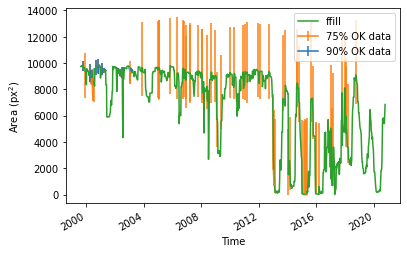

In [30]:
fig, ax = plt.subplots()
ax.errorbar(
    ts_baseline_low.index,
    ts_baseline_low,
    yerr=np.stack(
        [np.zeros(len(ts_baseline_low)), ts_baseline_low_upper - ts_baseline_low]
    ),
    label="75% OK data",
    c="C1",
)
ax.errorbar(
    ts_baseline.index,
    ts_baseline,
    yerr=np.stack([np.zeros(len(ts_baseline)), ts_baseline_upper - ts_baseline]),
    label="90% OK data",
    c="C0",
)
ts_ffill.plot(ax=ax, c="C2", label="ffill")
plt.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Area (px$^2$)");

An equally meaningful approach would be to take the _next_ observation instead.

In [31]:
df_bfilled = df_masked.bfill(axis=0)

In [32]:
ts_bfill = df_bfilled.sum(axis=1)

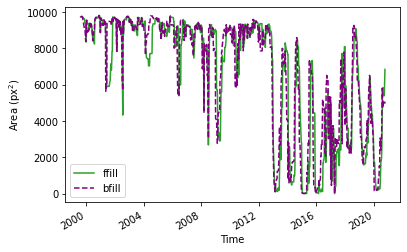

In [33]:
fig, ax = plt.subplots()
ts_ffill.plot(ax=ax, c="C2", label="ffill")
ts_bfill.plot(ax=ax, c="purple", label="bfill", linestyle="--")
plt.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Area (px$^2$)");

We can also average these (on a per-pixel level!), which means we're taking the average of the previous and next WOfS values:

In [34]:
ts_avgfill = (df_ffilled + df_bfilled).sum(axis=1) / 2

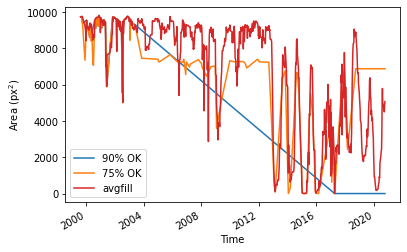

In [35]:
fig, ax = plt.subplots()
ts_baseline.interpolate(method="time").plot(ax=ax, c="C0", label="90% OK")
ts_baseline_low.interpolate(method="time").plot(ax=ax, c="C1", label="75% OK")
ts_avgfill.plot(ax=ax, c="C3", label="avgfill")
plt.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Area (px$^2$)");

Finally we could also linearly interpolate each pixel. This will largely be very similar to the average fill, except if there is a long series of unobserved times.

In [36]:
df_linfilled = df_masked.interpolate(method="time", axis=0)

In [37]:
ts_linfilled = df_linfilled.sum(axis=1)

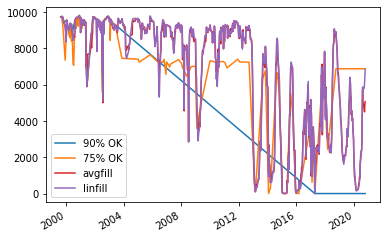

In [38]:
fig, ax = plt.subplots()
ts_baseline.interpolate(method="time").plot(ax=ax, c="C0", label="90% OK")
ts_baseline_low.interpolate(method="time").plot(ax=ax, c="C1", label="75% OK")
ts_avgfill.plot(ax=ax, c="C3", label="avgfill")
ts_linfilled.plot(ax=ax, c="C4", label="linfill")
plt.legend()

## Mean observation imputation

Take the mean over all-time as the value for each missing pixel. This is a fairly standard method for imputing values in prediction tasks, but it's very rough.

In [39]:
mean_values = df_masked.mean(axis=0)

In [40]:
df_meanfill = df_masked.fillna(value=mean_values)

In [41]:
ts_meanfill = df_meanfill.sum(axis=1)

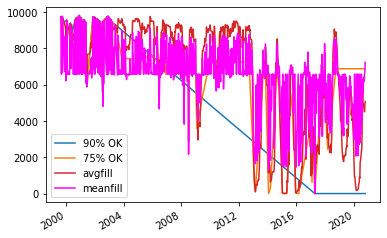

In [43]:
fig, ax = plt.subplots()
ts_baseline.interpolate(method="time").plot(ax=ax, c="C0", label="90% OK")
ts_baseline_low.interpolate(method="time").plot(ax=ax, c="C1", label="75% OK")
ts_avgfill.plot(ax=ax, c="C3", label="avgfill")
ts_meanfill.plot(ax=ax, c="magenta", label="meanfill")
plt.legend()

A very clear pattern can be seen where the mean water level is preferentially chosen, which will correspond to days with very few observations.

## Conclusion

Average-filling provides a simple and efficient way to impute WOfS across missing data, while seeming to add less bias toward dry values. Forward- or backward-filling would also be OK, but we might as well be time-symmetric. Patterns are very clearly pulled out that are not visible in the non-imputed, interpolated time series.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** November 2020

**Compatible datacube version:**

In [44]:
datacube.__version__

'1.8.3'

## Tags